### Import libraries

In [1]:
import pandas as pd
import imageio
import sys
sys.path.append('../utils')
import visualization
import generic
import project_utils

import os


epidemic_years = ['2012_13', '2015_16', '2018_19', '2023_24']

pygame 2.6.1 (SDL 2.28.4, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Load Data

In [2]:
dengue_data = pd.read_csv('../data/processed/dengue_data_with_coordinates.csv')
health_centers = pd.read_csv('../data/processed/health_centers.csv')
dengue_data.columns

Index(['dt_notific', 'CodMun', 'SemEpi', 'dt_nasc', 'nu_idade_n', 'Sexo',
       'id_bairro', 'nm_bairro', 'classi_fin', 'dt_obito', 'coordx', 'coordy',
       'diagnostic', 'abrange', 'cdabrange', 'Ano_Caso', 'Mes_Caso',
       'Dia_Caso', 'DiaC', 'MesC', 'AnoC', 'Dengue', 'Idade', 'anoCepid',
       'nanoCepid', 'Mes_Epid', 'Cseason', 'Clustro', 'Cquinzena',
       'Cquinzepid', 'CaClustro', 'cddist', 'distrito', 'qdnte', 'longitude',
       'latitude'],
      dtype='object')

### Samples 

In [3]:
print(f'Number of samples: {dengue_data.shape[0]}')
print(f'Samples with date: {dengue_data[dengue_data["dt_notific"].notna()].shape[0]}')
print(f'Samples with coordinates: {dengue_data[dengue_data["latitude"].notna()].shape[0]}')
print(f'Samples without coordinates: {dengue_data[dengue_data["latitude"].isna()].shape[0]}')
print(f'Samples without coordinates with neighborhood: {dengue_data[(dengue_data["latitude"].isna() & ~(dengue_data["nm_bairro"].isna()) )].shape[0]}')
print(f'Samples without coordinates without neighborhood: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["nm_bairro"].isna()) )].shape[0]}')
print(f'Samples without coordinates without neighborhood with district: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["nm_bairro"].isna()) & ~(dengue_data["distrito"].isna()) )].shape[0]}')
print(f'Samples without coordinates without neighborhood without district: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["nm_bairro"].isna()) & (dengue_data["distrito"].isna()) )].shape[0]}')


Number of samples: 691393
Samples with date: 691393
Samples with coordinates: 486427
Samples without coordinates: 204966
Samples without coordinates with neighborhood: 197976
Samples without coordinates without neighborhood: 6990
Samples without coordinates without neighborhood with district: 6296
Samples without coordinates without neighborhood without district: 694


In [4]:
print(f'Samples with coordinates without health center: {dengue_data[(dengue_data["latitude"].notna() & (dengue_data["abrange"] == "NAO DETERMINADA"))].shape[0]}')
print(f'Samples without coordinates with health center: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["abrange"] != "NAO DETERMINADA"))].shape[0]}')
print(f'Samples without coordinates without health center: {dengue_data[(dengue_data["latitude"].isna() & (dengue_data["abrange"] == "NAO DETERMINADA"))].shape[0]}')

Samples with coordinates without health center: 219636
Samples without coordinates with health center: 0
Samples without coordinates without health center: 204966


#### Samples by year


<Axes: title={'center': 'Samples by year'}, xlabel='anoCepid'>

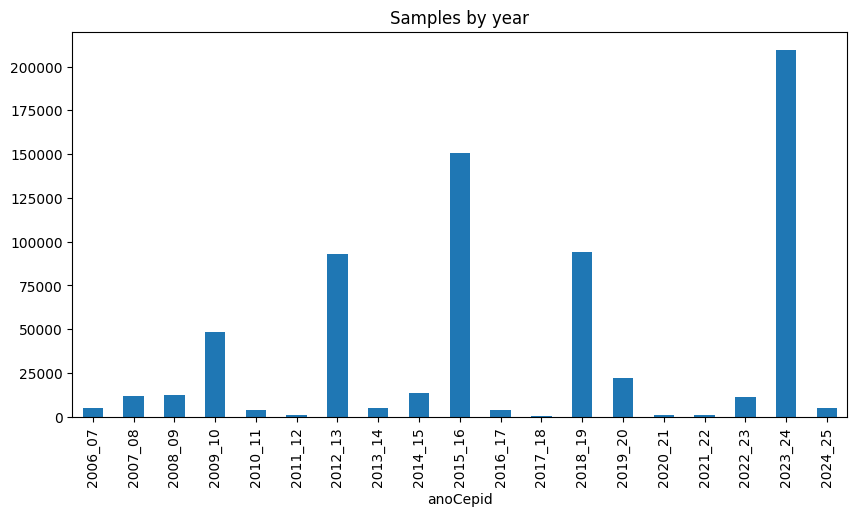

In [5]:
dengue_data['anoCepid'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), title='Samples by year')

In [6]:
for year in dengue_data['anoCepid'].unique():
    deaths = dengue_data[dengue_data['anoCepid'] == year]['dt_obito'].notna().sum()
    print(f'Number of deaths for {year}: {deaths}')

Number of deaths for 2018_19: 41
Number of deaths for 2023_24: 132
Number of deaths for 2015_16: 54
Number of deaths for 2024_25: 6
Number of deaths for 2009_10: 2
Number of deaths for 2016_17: 6
Number of deaths for 2012_13: 5
Number of deaths for 2014_15: 5
Number of deaths for 2019_20: 9
Number of deaths for 2006_07: 0
Number of deaths for 2022_23: 10
Number of deaths for 2007_08: 0
Number of deaths for 2010_11: 0
Number of deaths for 2013_14: 3
Number of deaths for 2008_09: 0
Number of deaths for 2021_22: 1
Number of deaths for 2020_21: 0
Number of deaths for 2017_18: 1
Number of deaths for 2011_12: 0


#### No Coordinates samples by year


<Axes: title={'center': 'Samples without coordinates by year'}, xlabel='anoCepid'>

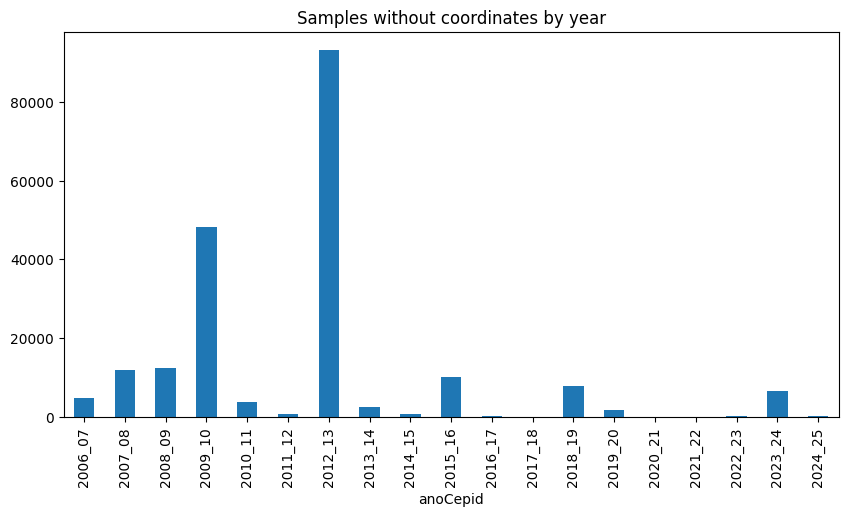

In [7]:
dengue_data[dengue_data["latitude"].isna()]['anoCepid'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), title='Samples without coordinates by year')

#### Cases with same coordinates

In [8]:
same_coord_cases = dengue_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')
house_with_n_cases = same_coord_cases['count'].groupby(same_coord_cases['count']).count()
pd.set_option('display.max_rows', None)
display(house_with_n_cases)
pd.set_option('display.max_rows', 10)

count
1      135804
2       54822
3       25498
4       12309
5        6526
6        3299
7        1981
8        1160
9         751
10        445
11        307
12        245
13        160
14        116
15        101
16         70
17         55
18         64
19         35
20         32
21         20
22         33
23         22
24         26
25         22
26         12
27         15
28          9
29         14
30         10
31         13
32          6
33          7
34         12
35          4
36          7
37          4
38          6
39          5
40          6
41          3
42          3
43          7
44          3
45          1
46          4
47          2
48          1
49          3
50          4
52          2
54          2
55          1
56          1
57          2
58          4
59          1
60          4
61          2
62          1
64          3
65          1
66          1
67          2
68          1
69          1
71          1
73          1
74          1
77          2
80          1


### Health Centers and Districts

In [9]:
pd.set_option('display.max_rows', None)
dengue_data['abrange'].value_counts()

abrange
NAO DETERMINADA                         424602
C.S.SANTA TEREZINHA                       4557
C.S.PARAISO                               3909
C.S.GLORIA                                3826
C.S.HORTO                                 3531
C.S.MARCO ANTONIO DE MENEZES              3441
C.S.NORALDINO DE LIMA                     3183
C.S.POMPEIA                               3099
C.S.SANTA AMELIA                          3069
C.S.SAO GERALDO                           3024
C.S.LINDEIA                               2892
C.S.VALE DO JATOBA                        2853
C.S.NAZARE                                2775
C.S.SALGADO FILHO                         2698
C.S.ALCIDES LINS                          2620
C.S.JARDIM MONTANHES                      2610
C.S.JARDIM GUANABARA                      2577
C.S.PINDORAMA                             2531
C.S.DOM BOSCO                             2511
C.S.REGINA                                2493
C.S.BARREIRO DE CIMA                      2425
C.S.V

In [10]:
pd.set_option('display.max_rows', 20)
dengue_data['distrito'].value_counts()


distrito
NORDESTE      104944
NORTE          96748
VENDA NOVA     91540
BARREIRO       81272
LESTE          77138
NOROESTE       76078
OESTE          64200
PAMPULHA       61526
CENTRO-SUL     36832
Name: count, dtype: int64

#### Closest Health Centers

In [11]:
dengue_data.iloc[:5][['latitude','longitude']]

,latitude,longitude
0,-19.980407,-44.052970
1,-19.998910,-44.029173
2,-19.995018,-44.032810
3,NaN,NaN
4,-19.981607,-44.020926


### Ovitraps data

In [12]:
ovitraps_data = pd.read_csv('../data/processed/ovitraps_data_with_coordinates.csv')
ovitraps_data['abrange'].value_counts()


abrange
C.S.SANTA AMELIA               12012
C.S.NOSSA SENHORA DE FATIMA    11915
C.S.CONJ. SANTA MARIA           9705
C.S.TREVO                       9074
C.S.MENINO JESUS                8192
                               ...  
C.S.PRIMEIRO DE MAIO            1255
C.S.SANTA LUCIA                 1232
C.S.NOVO AARAO REIS             1064
C.S.ITAMARATI 2                  771
NAO DETERMINADA                   56
Name: count, Length: 152, dtype: int64

# Create maps

### Cases in BH grouped by coordinates 

In [13]:
filter = 100
coordinates = dengue_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')
coordinates = coordinates[coordinates['count'] > filter].sort_values(by='count', ascending=False).reset_index(drop=True)
coordinates['cluster'] = coordinates.index


mymap = generic.create_map(coordinates[['latitude', 'longitude']].values)
mymap = generic.add_clustered_markers_to_map(mymap, coordinates)

health_centers_coordinates = health_centers[['latitude','longitude']].dropna(axis=0).values
mymap = generic.add_points_to_map(
    mymap=mymap,
    coordinates=health_centers_coordinates,
    size=7
)
generic.save_file(file=mymap,folder='../results/correlation/', file_name='dengue_cases_by_coordinates.html')
mymap

### Cases in BH grouped by clusters

In [14]:
coordinates = dengue_data[['latitude','longitude']].dropna(axis=0).values
cluster_data = generic.cluster_points(coordinates)
mymap = generic.create_map(coordinates)
mymap = generic.add_clustered_markers_to_map(mymap, cluster_data)

health_centers_coordinates = health_centers[['latitude','longitude']].dropna(axis=0).values
mymap = generic.add_points_to_map(
    mymap=mymap,
    coordinates=health_centers_coordinates,
    size=7
)
generic.save_file(file=mymap,folder='../results/correlation/', file_name='dengue_cases_by_clusters.html')
mymap

### Cases by Epidemic Year

In [15]:
"""
for year in dengue_data['anoCepid'].unique():
    coord_year = dengue_data[dengue_data['anoCepid'] == year][['latitude','longitude']].dropna(axis=0).values
    if coord_year.shape[0] == 0:
        print(f'No coordinates for year {year}')
        continue
    cluster_data_year = generic.cluster_points(coord_year)
    mymap_year = generic.create_map(coord_year, title=f'Dengue cases in {year}')
    mymap_year = generic.add_clustered_markers_to_map(mymap_year, cluster_data_year)
    generic.save_file(file=mymap_year,folder='../results/correlation/years/', file_name=f'dengue_cases_in_{year}.html')
"""

"\nfor year in dengue_data['anoCepid'].unique():\n    coord_year = dengue_data[dengue_data['anoCepid'] == year][['latitude','longitude']].dropna(axis=0).values\n    if coord_year.shape[0] == 0:\n        print(f'No coordinates for year {year}')\n        continue\n    cluster_data_year = generic.cluster_points(coord_year)\n    mymap_year = generic.create_map(coord_year, title=f'Dengue cases in {year}')\n    mymap_year = generic.add_clustered_markers_to_map(mymap_year, cluster_data_year)\n    generic.save_file(file=mymap_year,folder='../results/correlation/years/', file_name=f'dengue_cases_in_{year}.html')\n"

#### GIF

In [16]:
"""
images = [] 
dirname = '../results/correlation/years/'
for dirpath, _, filenames in os.walk(dirname, topdown=True):
    for file in filenames:
        path = os.path.join(dirname, file)
        path = visualization.convert_html_to_image(path)
        images.append(imageio.imread(path))
        
imageio.mimsave(f'{dirname}map.gif', images, fps = 1)  # 1 second per frame
"""

"\nimages = [] \ndirname = '../results/correlation/years/'\nfor dirpath, _, filenames in os.walk(dirname, topdown=True):\n    for file in filenames:\n        path = os.path.join(dirname, file)\n        path = visualization.convert_html_to_image(path)\n        images.append(imageio.imread(path))\n        \nimageio.mimsave(f'{dirname}map.gif', images, fps = 1)  # 1 second per frame\n"